In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split

# ========== Load Dataset ==========
file_path = "/kaggle/input/mergefile/Merged_Disasters(2).csv"  # Update folder & filename if different
df = pd.read_csv(file_path)

# ========== Stratified Split (80% Train, 20% Test) ==========
train_df, test_df = train_test_split(df, test_size=0.20, stratify=df["Binary_class"], random_state=42)

# ========== Save Split Data (Kaggle uses `/kaggle/working` for output) ==========
train_df.to_csv("/kaggle/working/train_data.csv", index=False)
test_df.to_csv("/kaggle/working/test_data.csv", index=False)

# ========== Summary Table ==========
split_summary = pd.DataFrame({
    "Train (80%)": train_df["Binary_class"].value_counts(),
    "Test (20%)": test_df["Binary_class"].value_counts(),
    "Total": df["Binary_class"].value_counts()
}).T

# ========== Save Summary Table ==========
split_summary.to_csv("/kaggle/working/split_summary.csv")

# ========== Display ==========
print("\nData Split Summary:\n", split_summary)
print("\n✅ 80-20 Train-Test split completed and saved to `/kaggle/working/`.")



Data Split Summary:
 Binary_class  Non-Damage  Damage
Train (80%)        12403    2062
Test (20%)          3102     515
Total              15505    2577

✅ 80-20 Train-Test split completed and saved to `/kaggle/working/`.


Before SMOTE - Train: [12403  2062]
After SMOTE - Train: [12403 12403]
Before SMOTE - Test: [3102  515]
After SMOTE - Test: [3102 3102]

📊 Test Evaluation Summary:
✅ Test Accuracy   : 0.8050
✅ Test ROC-AUC    : 0.8740
✅ Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.87      0.82      3102
           1       0.85      0.74      0.79      3102

    accuracy                           0.80      6204
   macro avg       0.81      0.80      0.80      6204
weighted avg       0.81      0.80      0.80      6204



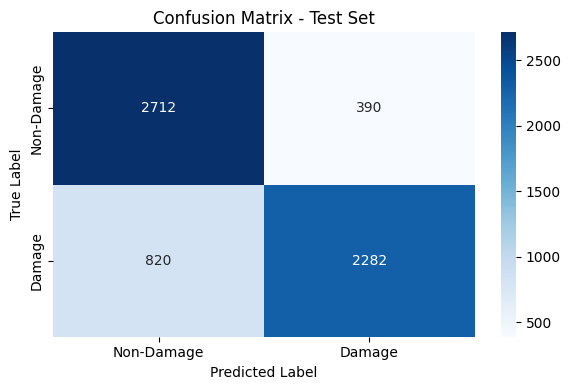

In [10]:
# ========== Imports ==========
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import joblib

# ========== Load Dataset ==========
train_df = pd.read_csv("/kaggle/working/train_data.csv")
test_df = pd.read_csv("/kaggle/working/test_data.csv")

# ========== Preprocess Labels ==========
label_map = {'damage': 1, 'non-damage': 0}
train_df['Binary_class'] = train_df['Binary_class'].str.strip().str.lower().map(label_map)
test_df['Binary_class'] = test_df['Binary_class'].str.strip().str.lower().map(label_map)

# ========== Handle Missing Text ==========
train_df['Processed_data'] = train_df['Processed_data'].fillna("")
test_df['Processed_data'] = test_df['Processed_data'].fillna("")

# ========== Combine for Unified Split ==========
full_df = pd.concat([train_df, test_df], ignore_index=True)
X = full_df['Processed_data']
y = full_df['Binary_class']

# ========== Stratified Train-Test Split (80-20) ==========
X_train_text, X_test_text, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# ========== TF-IDF Vectorization ==========
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english', ngram_range=(1, 2))
X_train = vectorizer.fit_transform(X_train_text).toarray()
X_test = vectorizer.transform(X_test_text).toarray()

# ========== Apply SMOTE to Train and Test Sets ==========
print("Before SMOTE - Train:", np.bincount(y_train))
smote = SMOTE(random_state=42, sampling_strategy=1.0)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
print("After SMOTE - Train:", np.bincount(y_train_smote))

print("Before SMOTE - Test:", np.bincount(y_test))
X_test_smote, y_test_smote = smote.fit_resample(X_test, y_test)
print("After SMOTE - Test:", np.bincount(y_test_smote))

# ========== Train Random Forest Model ==========
rf_model = RandomForestClassifier(
    n_estimators=80,
    max_depth=15,
    min_samples_split=10,
    min_samples_leaf=5,
    class_weight="balanced",
    random_state=42
)

rf_model.fit(X_train_smote, y_train_smote)

# ========== Save the Model and Vectorizer ==========
joblib.dump(rf_model, "/kaggle/working/random_forest_model.joblib")
joblib.dump(vectorizer, "/kaggle/working/tfidf_vectorizer.pkl")

# ========== Evaluate on SMOTE-applied Test Set ==========
y_test_pred = rf_model.predict(X_test_smote)
y_test_proba = rf_model.predict_proba(X_test_smote)[:, 1]
accuracy_test = accuracy_score(y_test_smote, y_test_pred)
roc_auc_test = roc_auc_score(y_test_smote, y_test_proba)
classification_rep_test = classification_report(y_test_smote, y_test_pred)

print("\n📊 Test Evaluation Summary:")
print(f"✅ Test Accuracy   : {accuracy_test:.4f}")
print(f"✅ Test ROC-AUC    : {roc_auc_test:.4f}")
print("✅ Classification Report:\n", classification_rep_test)

# ========== Confusion Matrix ==========
cm_test = confusion_matrix(y_test_smote, y_test_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_test, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Non-Damage', 'Damage'],
            yticklabels=['Non-Damage', 'Damage'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Test Set")
plt.tight_layout()
plt.show()
